In [3]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

# Load data

In [5]:
fpd = pd.read_csv('../dataframe_creation/complete_dataframe.csv',index_col=0, parse_dates=True)
fpd = fpd.fillna(1)

# Create predictor
Create a function that can take the the data and create a proper predictor for each intersection and store them in a dataframe. Then, it will predict the outcomes for the test dataset and store the results in another dataset.

In [4]:
def predictor(data,intersections,predictor,k):
    predictors = {}
    performance = {}
    confusion_matrices = {}
    features = {}
    sel = ['K302','K173','K414','K158','K402','K305']
    #print('K is set to ',k)
    for label in intersections:
        df = data.copy(deep=True)
        print('\nLabel: ',label)
        y = df[label][2:] #set label to be current intersection
        
        boundary = y.sort_values().head(k)[-1]#Get K lowest LOF score and use as boundary 
        print('Boundary is set to: ',boundary)
        y = y.apply(make_binary,boundary=boundary)
        
        y,y_test = split_data(y)
        #print('Length of y: ',len(y))

        for feature in intersections: # for each intersection create t-1 & t-2 feature
            df['t-1'+feature] = df[feature].shift(periods=1)
            df['t-2'+feature] = df[feature].shift(periods=2)
            df = df.drop(feature,axis=1) #Then, drop the original column
        
        if label in sel:
            X = df[2:]
            X,X_test = split_data(X)
            #print('Length of X: ',len(X))

            features[label] = X.columns

            #Create predictor and get best hyperparameters with grid search
            if predictor == 'dtree':
                model = dtree_grid_search(X,y)
            if predictor == 'lr':
                model = lr_grid_search(X,y)
            if predictor == 'gb':
                model = gb_grid_search(X,y)
            if predictor == 'rf':
                model = rf_grid_search(X,y)

            #Test model performance and print results
            y_pred = model.predict(X_test)
            try:
                auc = roc_auc_score(y_test, y_pred)
                accuracy = metrics.accuracy_score(y_test, y_pred)
                f1 = metrics.f1_score(y_test, y_pred)
                precision = metrics.precision_score(y_test, y_pred)

                print('\nPrediction results: ')
                print('Area under the ROC curve: ',auc)
            except:
                print('!!!Error here when runnig AUC!!!')
            print("Accuracy:",accuracy)
            print("f1:",f1)
            print("Precision:",precision)
            print("Recall:",metrics.recall_score(y_test, y_pred))
            try:
                tn,fp,fn,tp = confusion_matrix(y_test, y_pred).ravel()
                print('tn',tn, 'fp',fp, 'fn',fn, 'tp',tp)

                predictors[label] = model
                performance[label] = auc,accuracy,f1,precision
                confusion_matrices[label] = list(confusion_matrix(y_test, y_pred).ravel())
            except:
                print('!!!Error in last part!!!')
        else:
            pass
        
    return predictors,performance,confusion_matrices,features

In [5]:
#Split data into train/val and test based on date
def split_data(df):
    df_test = df['2019-01-01':]
    df = df[:'2018-12-31']
    return df,df_test

#Make the label a binary of outlier or not.
def make_binary(row,boundary):
    if row <= boundary:
        row = 1
    else:
        row = 0
    return row

#Hyper parameter selection for Dtree
def dtree_grid_search(X,y):
    #param_grid = { 'criterion':['gini','entropy']}#,'min_samples_split' : [10]}#,'max_depth': [19]}
    dtree_model=DecisionTreeClassifier()
    #dtree_gscv = GridSearchCV(dtree_model, param_grid,cv=5, scoring="roc_auc")
    dtree_model.fit(X, y)
    return dtree_model

def lr_grid_search(X,y):
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 'solver':['lbfgs'] }
    lr = LogisticRegression()
    model = GridSearchCV(lr, param_grid,cv=5,scoring="roc_auc")
    model.fit(X, y)
    return model

def gb_grid_search(X,y):
    param_grid = {'learning_rate': [0.001, 0.01, 0.1, 1, 10] }
    gb = ensemble.GradientBoostingClassifier()
    model = GridSearchCV(gb, param_grid,cv=5, scoring="roc_auc")
    model.fit(X, y)
    return model

def rf_grid_search(X,y):
    #param_grid = {'n_estimators': [10,100] }
    rf = RandomForestClassifier(random_state = 2,n_estimators = 100)
    #model = GridSearchCV(rf, param_grid,cv=5, scoring="roc_auc")
    rf.fit(X, y)
    return rf

In [17]:
def plot_scores(auc,f1,prec,title):
    # set width of bar
    barWidth = 0.25

    # Set position of bar on X axis
    r1 = np.arange(len(auc))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]

    # Make the plot
    plt.figure(figsize=(15,10))
    plt.title(title)
    plt.bar(r1, auc, color='#7f6d5f', width=barWidth, edgecolor='white', label='auc')
    plt.bar(r2, f1, color='#557f2d', width=barWidth, edgecolor='white', label='f1')
    plt.bar(r3, prec, color='#2d7f5e', width=barWidth, edgecolor='white', label='prec')

    # Add xticks on the middle of the group bars
    plt.xlabel('Location', fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(auc))], ints)

    # Create legend & Show graphic

    plt.legend()
    plt.show()
    return

## Testing ground

In [7]:
intersections = [
    'K302','K173','K414','K158','K402','K305',
    'K071','K097','K124','K128','K159','K184','K189','K206','K225','K270','K304','K405','K406','K424','K430','K703','K704','K707','K711','K561','K504','K145','K250',
    'a12in','a12out','n211in','n211out','n141in','n141out','n142in','n142out','n143in','n143out'
]

# Random forest

In [8]:
a1,a2,a3,a4 = predictor(fpd,intersections,'rf',50)


Label:  K302
Boundary is set to:  0.7306087036925828

Prediction results: 
Area under the ROC curve:  0.7497598463016331
Accuracy: 0.9980842911877394
f1: 0.6
Precision: 0.75
Recall: 0.5
tn 2081 fp 1 fn 3 tp 3

Label:  K173
Boundary is set to:  0.7572706754842946


/Users/wesleyfitters/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wesleyfitters/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Prediction results: 
Area under the ROC curve:  0.5
Accuracy: 0.9985632183908046
f1: 0.0
Precision: 0.0
Recall: 0.0
tn 2085 fp 0 fn 3 tp 0

Label:  K414
Boundary is set to:  0.7529919403357282

Prediction results: 
Area under the ROC curve:  0.875
Accuracy: 0.9995210727969349
f1: 0.8571428571428571
Precision: 1.0
Recall: 0.75
tn 2084 fp 0 fn 1 tp 3

Label:  K158
Boundary is set to:  0.8219506026354174

Prediction results: 
Area under the ROC curve:  0.8
Accuracy: 0.9990421455938697
f1: 0.7499999999999999
Precision: 1.0
Recall: 0.6
tn 2083 fp 0 fn 2 tp 3

Label:  K402
Boundary is set to:  0.8048306217374189

Prediction results: 
Area under the ROC curve:  0.875
Accuracy: 0.9995210727969349
f1: 0.8571428571428571
Precision: 1.0
Recall: 0.75
tn 2084 fp 0 fn 1 tp 3

Label:  K305
Boundary is set to:  0.8243633130229433

Prediction results: 
Area under the ROC curve:  0.8
Accuracy: 0.9990421455938697
f1: 0.7499999999999999
Precision: 1.0
Recall: 0.6
tn 2083 fp 0 fn 2 tp 3

Label:  K071
Boun

In [9]:
#a110,a210,a310,a410 = predictor(fpd,intersections,'rf',10)

In [10]:
#a125,a225,a325,a425 = predictor(fpd,intersections,'rf',25)

In [11]:
#a150,a250,a350,a450 = predictor(fpd,intersections,'rf',50)

In [9]:
#a175,a275,a375,a475 = predictor(fpd,intersections,'rf',75)

In [8]:
#a1100,a2100,a3100,a4100 = predictor(fpd,intersections,'rf',100)

In [7]:
#a1150,a2150,a3150,a4150 = predictor(fpd,intersections,'rf',150)

In [6]:
#a1300,a2300,a3300,a4300 = predictor(fpd,intersections,'rf',300)

In [3]:
#a1500,a2500,a3500,a4500 = predictor(fpd,intersections,'rf',500)

In [4]:
#a11000,a21000,a31000,a41000 = predictor(fpd,intersections,'rf',1000)

In [5]:
#a15000,a25000,a35000,a45000 = predictor(fpd,intersections,'rf',5000)

# Dec. Tree

In [12]:
b1,b2,b3,b4 = predictor(fpd,intersections,'dtree',50)


Label:  K302
Boundary is set to:  0.7306087036925828

Prediction results: 
Area under the ROC curve:  0.7497598463016331
Accuracy: 0.9980842911877394
f1: 0.6
Precision: 0.75
Recall: 0.5
tn 2081 fp 1 fn 3 tp 3

Label:  K173
Boundary is set to:  0.7572706754842946

Prediction results: 
Area under the ROC curve:  0.6666666666666666
Accuracy: 0.9990421455938697
f1: 0.5
Precision: 1.0
Recall: 0.3333333333333333
tn 2085 fp 0 fn 2 tp 1

Label:  K414
Boundary is set to:  0.7529919403357282

Prediction results: 
Area under the ROC curve:  0.8742802303262956
Accuracy: 0.9980842911877394
f1: 0.6
Precision: 0.5
Recall: 0.75
tn 2081 fp 3 fn 1 tp 3

Label:  K158
Boundary is set to:  0.8219506026354174

Prediction results: 
Area under the ROC curve:  0.7995199231877101
Accuracy: 0.9980842911877394
f1: 0.6
Precision: 0.6
Recall: 0.6
tn 2081 fp 2 fn 2 tp 3

Label:  K402
Boundary is set to:  0.8048306217374189

Prediction results: 
Area under the ROC curve:  0.875
Accuracy: 0.9995210727969349
f1: 0.857

# Logistic regression

In [13]:
c1,c2,c3,c4 = predictor(fpd,intersections,'lr',50)


Label:  K302
Boundary is set to:  0.7306087036925828


/Users/wesleyfitters/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wesleyfitters/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wesleyfitters/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wesleyfitters/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wesleyfitters/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs faile


Prediction results: 
Area under the ROC curve:  0.7497598463016331
Accuracy: 0.9980842911877394
f1: 0.6
Precision: 0.75
Recall: 0.5
tn 2081 fp 1 fn 3 tp 3

Label:  K173
Boundary is set to:  0.7572706754842946


/Users/wesleyfitters/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wesleyfitters/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wesleyfitters/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wesleyfitters/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wesleyfitters/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs faile


Prediction results: 
Area under the ROC curve:  0.6666666666666666
Accuracy: 0.9990421455938697
f1: 0.5
Precision: 1.0
Recall: 0.3333333333333333
tn 2085 fp 0 fn 2 tp 1

Label:  K414
Boundary is set to:  0.7529919403357282


/Users/wesleyfitters/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wesleyfitters/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wesleyfitters/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wesleyfitters/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wesleyfitters/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs faile


Prediction results: 
Area under the ROC curve:  0.875
Accuracy: 0.9995210727969349
f1: 0.8571428571428571
Precision: 1.0
Recall: 0.75
tn 2084 fp 0 fn 1 tp 3

Label:  K158
Boundary is set to:  0.8219506026354174


/Users/wesleyfitters/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wesleyfitters/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wesleyfitters/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wesleyfitters/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wesleyfitters/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs faile


Prediction results: 
Area under the ROC curve:  0.799759961593855
Accuracy: 0.9985632183908046
f1: 0.6666666666666665
Precision: 0.75
Recall: 0.6
tn 2082 fp 1 fn 2 tp 3

Label:  K402
Boundary is set to:  0.8048306217374189


/Users/wesleyfitters/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wesleyfitters/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wesleyfitters/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wesleyfitters/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wesleyfitters/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs faile


Prediction results: 
Area under the ROC curve:  0.75
Accuracy: 0.9990421455938697
f1: 0.6666666666666666
Precision: 1.0
Recall: 0.5
tn 2084 fp 0 fn 2 tp 2

Label:  K305
Boundary is set to:  0.8243633130229433


/Users/wesleyfitters/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wesleyfitters/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wesleyfitters/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wesleyfitters/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wesleyfitters/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs faile


Prediction results: 
Area under the ROC curve:  0.9
Accuracy: 0.9995210727969349
f1: 0.888888888888889
Precision: 1.0
Recall: 0.8
tn 2083 fp 0 fn 1 tp 4

Label:  K071
Boundary is set to:  0.7698544126651468

Label:  K097
Boundary is set to:  0.8266954653424617

Label:  K124
Boundary is set to:  0.8845122400517309

Label:  K128
Boundary is set to:  0.7525199591873765

Label:  K159
Boundary is set to:  0.7283456451164059

Label:  K184
Boundary is set to:  0.6298304810739711

Label:  K189
Boundary is set to:  0.7474264046781771

Label:  K206
Boundary is set to:  0.8059338513051981

Label:  K225
Boundary is set to:  0.7227470601760492

Label:  K270
Boundary is set to:  0.6670942327576516

Label:  K304
Boundary is set to:  0.6061800373193578

Label:  K405
Boundary is set to:  0.8294090524963054

Label:  K406
Boundary is set to:  0.6861307688075114

Label:  K424
Boundary is set to:  0.7974031523034429

Label:  K430
Boundary is set to:  0.8820679461009083

Label:  K703
Boundary is set to:  0

# Visualize prediction results 

## Bar group per intersection with AUC/F1/Precision

In [14]:
sel = ['K302','K173','K414','K158','K402','K305']

In [23]:
scores = c2

In [24]:
ints = scores.keys()

auc=[]
acc=[]
f1=[]
prec=[]

for i in ints:
    if i in sel:
        auc.append(scores[i][0])
        acc.append(scores[i][1])
        f1.append(scores[i][2])
        prec.append(scores[i][3])
    else: pass

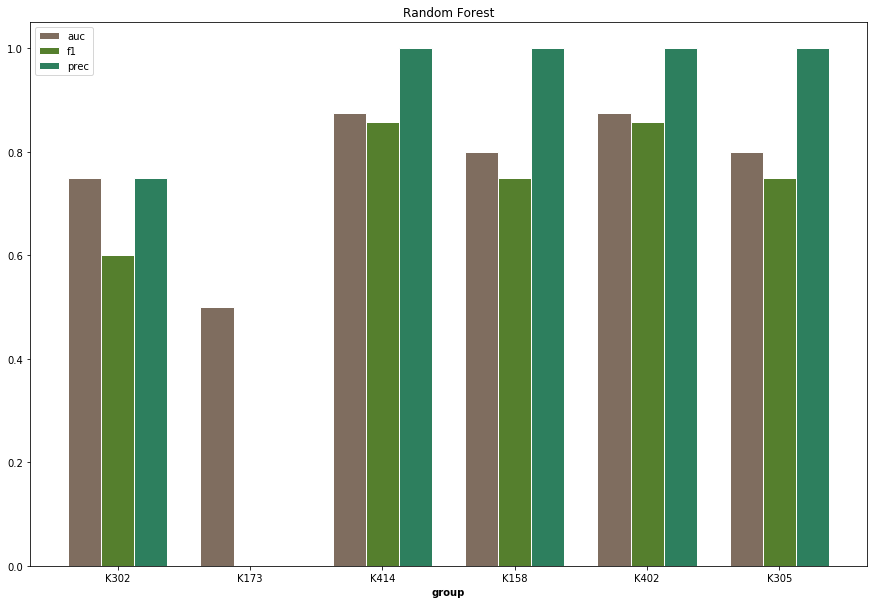

In [34]:
plot_scores(auc,f1,prec,'Random Forest')

### Random Forest

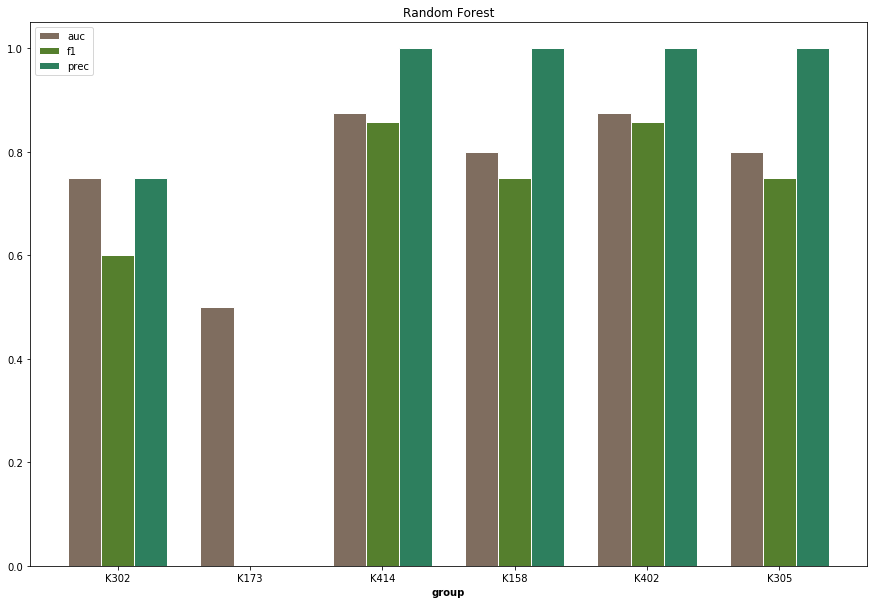

In [197]:
plot_scores(auc,f1,prec,'Random Forest')

### Dec. Tree

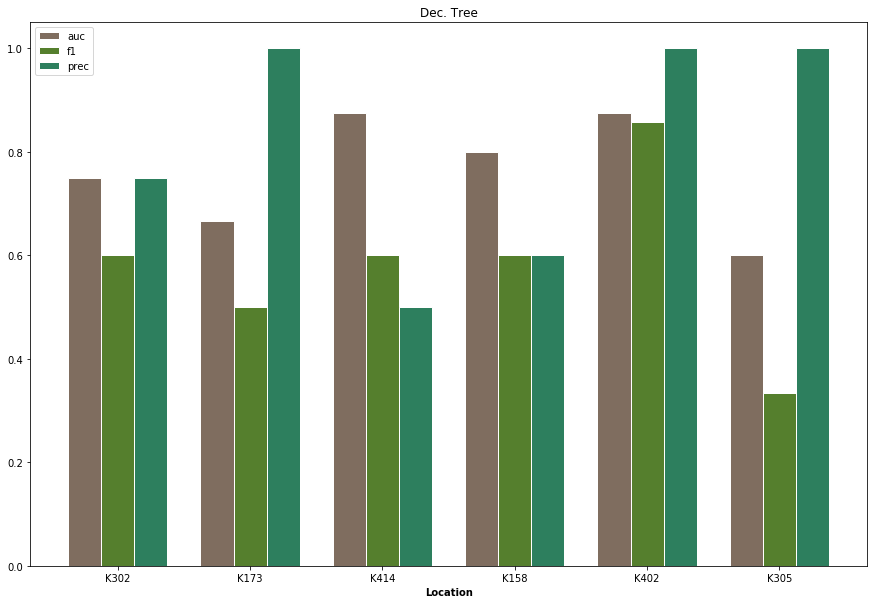

In [22]:
plot_scores(auc,f1,prec,'Dec. Tree')

### Logistic Regression

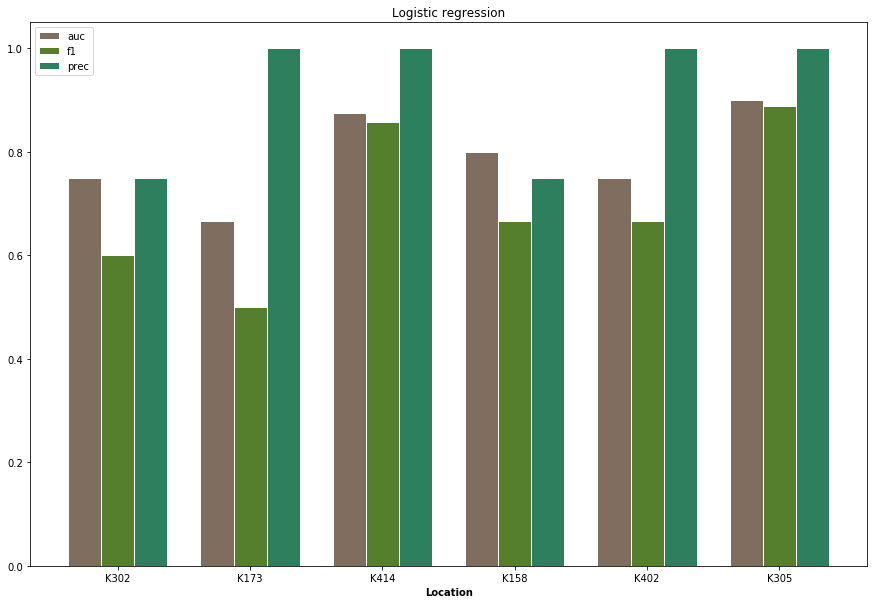

In [25]:
plot_scores(auc,f1,prec,'Logistic regression')

## Compare all intersections' ROC and see which ones are scoring least

In [249]:
ints = a2.keys()

auc=[]
acc=[]
f1=[]
prec=[]

for i in ints:
    auc.append(a2[i][0])
    acc.append(a2[i][1])
    f1.append(a2[i][2])
    prec.append(a2[i][3])

In [243]:
#plot_scores(auc,f1,prec,'All Intersections')

In [263]:
def plot(auc,title,ints):
    y_pos = np.arange(len(auc))
    # Make the plot
    plt.figure(figsize=(15,10))
    plt.title(title)
    plt.barh(y_pos,auc[::-1], color='#7f6d5f', edgecolor='white', label='auc')

    # Add xticks on the middle of the group baxrs
    plt.ylabel('group', fontweight='bold')
    plt.yticks([r for r in range(len(auc))], list(ints)[::-1])

    # Create legend & Show graphic
    plt.legend()
    plt.show()
    return

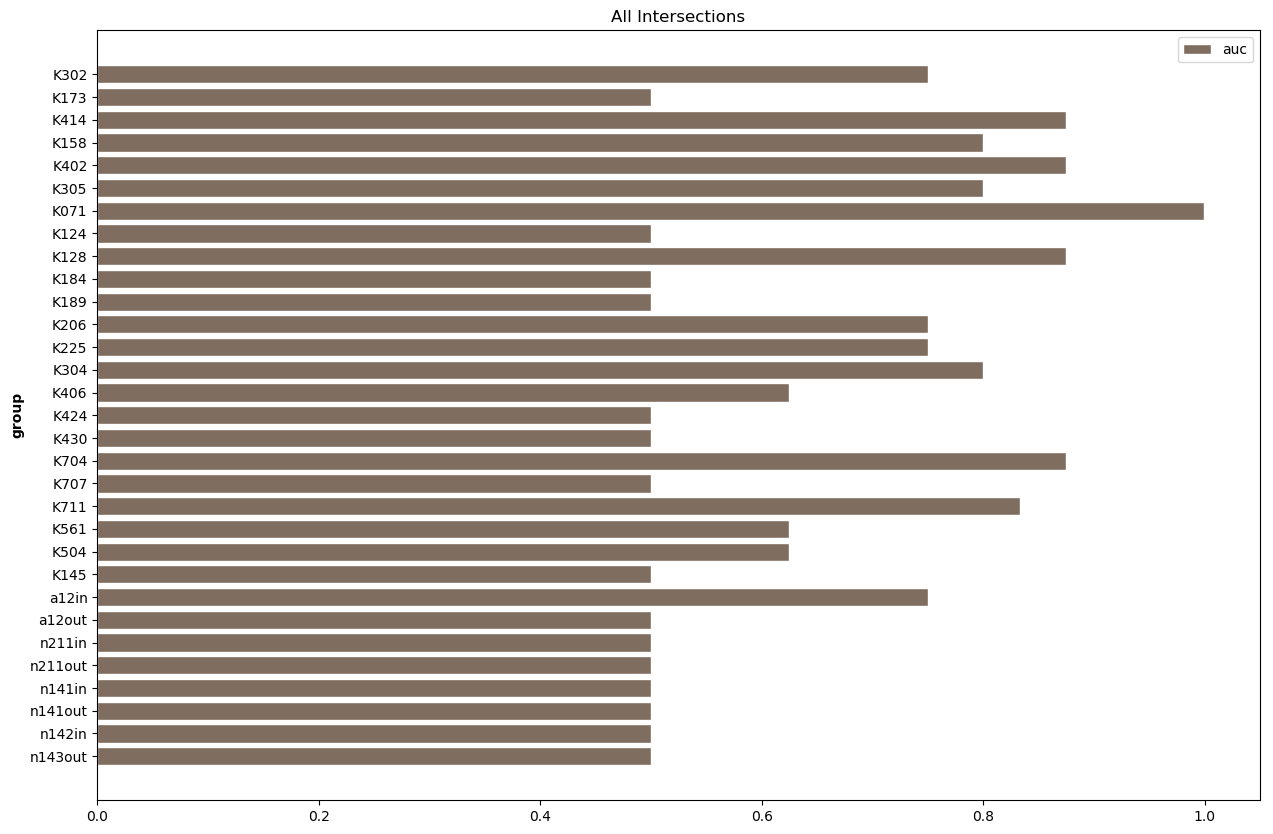

In [264]:
plot(auc,'All Intersections',ints)

## Iterate with increasing K

In [165]:
outcomes = [a210,a225,a250,a275,a2100,a2150,a2300,a2500,a21000,a25000]

In [169]:
sel

['K302', 'K173', 'K414', 'K158', 'K402', 'K305']

In [170]:
li = []
for s in sel:
    auc = []
    for outcome in outcomes:
        scores = outcome
        ints = scores.keys()
        #auc=[]

        for i in ints:
            if i == s:
                auc.append(scores[i][0])
            else: pass
    li.append(auc)

In [167]:
ticks = ['10','25','50','75','100','150','300','500','1000','5000']
ndf = pd.DataFrame(li)
ndf.columns = ticks
ndf = ndf.swapaxes("index", "columns")
ndf.columns = sel

In [187]:
ndf

,K302,K173,K414,K158,K402,K305
10,0.749760,0.500000,0.666667,0.666667,0.500000,0.750000
25,1.000000,0.500000,0.833333,0.833094,0.625000,0.875000
50,0.749760,0.500000,0.875000,0.800000,0.875000,0.800000
75,0.714045,0.500000,0.800000,0.800000,0.875000,0.750000
100,0.714045,0.625000,0.714286,0.714045,0.875000,0.714286
150,0.650000,0.600000,0.625000,0.625000,0.875000,0.650000
300,0.587994,0.700000,0.548387,0.571187,0.749760,0.593750
500,0.546632,0.642857,0.516393,0.539230,0.649759,0.574758
1000,0.520585,0.566667,0.507812,0.527530,0.548144,0.541423
5000,0.513681,0.507713,0.515900,0.516012,0.512200,0.509368


NameError: name 'ndf' is not defined

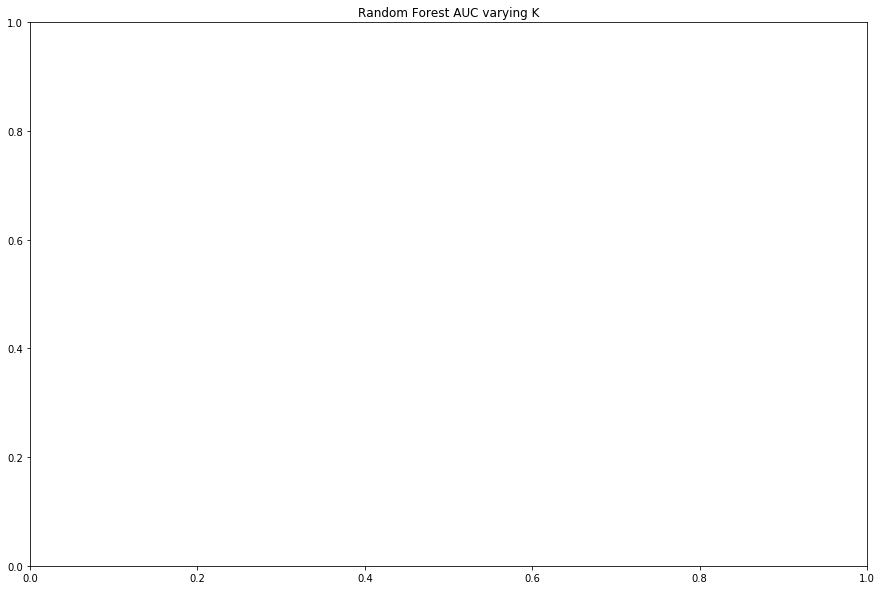

In [26]:
plt.figure(figsize=(15,10))
plt.title('Random Forest AUC varying K')
plt.plot(ndf)
plt.xlabel('K', fontweight='bold')
plt.xticks([r for r in range(len(auc))], ticks)
plt.legend(ndf.columns)
plt.show()

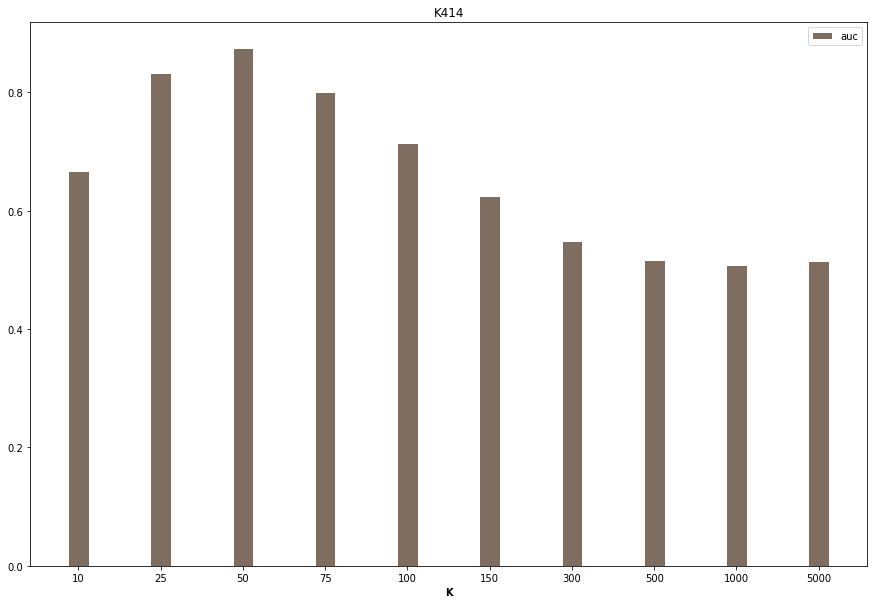

In [191]:
auc = li[2]
barWidth = 0.25
r1 = np.arange(len(auc))
plt.figure(figsize=(15,10))
plt.title(sel[2])
plt.bar(r1, auc, color='#7f6d5f', width=barWidth, edgecolor='white', label='auc')

# Add xticks on the middle of the group bars
plt.xlabel('K', fontweight='bold')
plt.xticks([r for r in range(len(auc))], ticks)

# Create legend & Show graphic

plt.legend()
plt.show()